In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import pandas as pd
import numpy as np
import random

class GNN(torch.nn.Module):
    def __init__(self, num_features):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, 128)
        self.layer1 = nn.Linear(21, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128,64)
        self.layer4 = nn.Linear(64,2)

    def forward(self, data, df):
        x, edge_index = data.x, data.edge_index
        out = torch.relu(self.layer1(df))
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        out = torch.relu(self.layer2(out))
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = torch.sigmoid(x)
        out = torch.relu(self.layer3(out))
        out = self.layer4(out)
  
        return out

def create_graph(data):
    # Create a graph structure as per your choice
    x = torch.tensor(data.iloc[:, 1:].values, dtype=torch.float)
    edge_index = torch.tensor([[i, i+1] for i in range(len(data)-1)], dtype=torch.long).t().contiguous()
    y = torch.tensor(data.iloc[:, 0].values, dtype=torch.float)

    graph = Data(x=x, edge_index=edge_index, y=y)
    return graph


# Load dataset
df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Split the dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Split data into features and labels
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                                                    
# Convert data to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Create graphs
train_graph = create_graph(train_df)
test_graph = create_graph(test_df)

# Initialize GNN model
model = GNN(train_graph.num_features)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
loss_values = []
for epoch in range(1000):
    optimizer.zero_grad()
    out = model(train_graph, X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()

    loss_values.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {loss}")

# Test the model
model.eval()
with torch.no_grad():
    test_pred = model(test_graph,X_test)
    _, test_pred = torch.max(test_pred, 1)

# Calculate metrics
f1 = f1_score(y_test, test_pred)
precision = precision_score(y_test, test_pred)
recall = recall_score(y_test, test_pred)
acc = accuracy_score(y_test, test_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {acc}")


Epoch: 0, Loss: 0.6919518113136292
Epoch: 10, Loss: 0.6798170804977417
Epoch: 20, Loss: 0.6060970425605774
Epoch: 30, Loss: 0.5496618747711182
Epoch: 40, Loss: 0.5285579562187195
Epoch: 50, Loss: 0.524056077003479
Epoch: 60, Loss: 0.518791139125824
Epoch: 70, Loss: 0.5164831876754761
Epoch: 80, Loss: 0.5146235823631287
Epoch: 90, Loss: 0.5147782564163208
Epoch: 100, Loss: 0.5116235017776489
Epoch: 110, Loss: 0.5119469165802002
Epoch: 120, Loss: 0.5105205774307251
Epoch: 130, Loss: 0.5079315304756165
Epoch: 140, Loss: 0.5080463886260986
Epoch: 150, Loss: 0.5092862844467163
Epoch: 160, Loss: 0.5055505037307739
Epoch: 170, Loss: 0.5047088861465454
Epoch: 180, Loss: 0.5044768452644348
Epoch: 190, Loss: 0.5047823190689087
Epoch: 200, Loss: 0.5053019523620605
Epoch: 210, Loss: 0.50679612159729
Epoch: 220, Loss: 0.5005393624305725
Epoch: 230, Loss: 0.5026161670684814
Epoch: 240, Loss: 0.5020282864570618
Epoch: 250, Loss: 0.5099568963050842
Epoch: 260, Loss: 0.4995725154876709
Epoch: 270, Loss

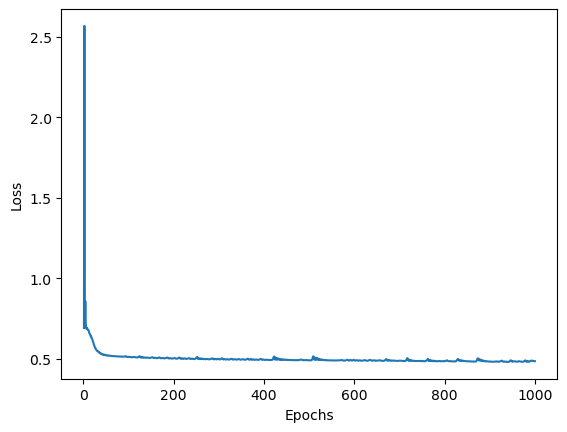

In [55]:
import matplotlib.pyplot as plt

#for i in range(len(loss_values)):
    #loss_values[i] = loss_values[i].detach().numpy()

plt.plot(np.linspace(1,1000,1000),loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Deep learning of GNN')
plt.show()